In [2]:
import kagglegym
import numpy as np
import pandas as pd

# sklearn libraries
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

pd.set_option('display.max_columns', 120)

In [3]:



environment = kagglegym.make() # This creates an environment in the API for me to play in
observation = environment.reset() # Resets to first observations "view of what you can see presently"

excl = [environment.ID_COL_NAME, environment.TARGET_COL_NAME, environment.TIME_COL_NAME,
environment.SAMPLE_COL_NAME]
col = [c for c in observation.train.columns if c not in excl]

from scipy import stats

df_old = observation.train
df = df_old[(np.abs(stats.zscore(df_old["y"])) < 3.6)]
#df = observation.train
df_full = pd.read_hdf('../input/train.h5')
d_mean= df[col].median(axis=0)


min_y = df["y"].min()
max_y = df["y"].max()
print (min_y, max_y)

X_train =df[col]
n = X_train.isnull().sum(axis=1)

for c in col: 
    r = pd.isnull(X_train.loc[:, c])
    X_train[c + '_nan_'] = r  
    d_mean[c + '_nan_'] = 0                                     

X_train = X_train.fillna(d_mean)
df = df.fillna(d_mean)
X_train['znull'] = n 
n = []

"""
So there are 111 columns present in the dataset.
1 id column
1 timestamp column
5 columns with name prefix 'derived'
63 columns with name prefix 'fundamental' - fundamental_0 to fundamental_63 - 'fundamental_4' is missing. Any specific reasons?
40 columns with name prefix 'technical' - technical_0 to technical_44 - technical_4, technical_8, technical_15, technical_23, technical_26 are missing.
1 target variable named 'y'
"""

"\nSo there are 111 columns present in the dataset.\n1 id column\n1 timestamp column\n5 columns with name prefix 'derived'\n63 columns with name prefix 'fundamental' - fundamental_0 to fundamental_63 - 'fundamental_4' is missing. Any specific reasons?\n40 columns with name prefix 'technical' - technical_0 to technical_44 - technical_4, technical_8, technical_15, technical_23, technical_26 are missing.\n1 target variable named 'y'\n"

In [ ]:
df.describe()

In [4]:
print('Number of rows: {}, Number of columns: {}'.format(*df.shape))

cols = [0, 0, 0]
for c in df.columns:
    if 'derived' in c: cols[0] += 1
    if 'fundamental' in c: cols[1] += 1
    if 'technical' in c: cols[2] += 1
print('Derived columns: {}, Fundamental columns: {}, Technical columns: {}'.format(*cols))
print('\nColumn dtypes:')
print(df.dtypes.value_counts())
print('\nint16 columns:')
print(df.columns[train_one.dtypes == 'int16'])
yellow = [len(df.id.unique()), len(df.timestamp.unique()) ]
print('We are tracking {} unique assets over {} periods.'.format(*yellow))


# I love this piece of code, it gives you a quick count of the type of columns. 


Number of rows: 793394, Number of columns: 111
Derived columns: 5, Fundamental columns: 63, Technical columns: 40

Column dtypes:
float32    109
int16        2
dtype: int64

int16 columns:


NameError: name 'train_one' is not defined

Looks like we have 1,424 assets that we are tracking across 1,813 time periods. We can't make any assumptions about the time period length - it could be days, hours, minutes, etc. as long as the period is uniform.
The set of assets could be considered as the market portfolio. It would be interesting to see if these assets could be grouped into classes based on the observed data and features. For example, asset classes may be equities, bonds, etc.
One approach may be to determine market return for a specific time period, and based on that predict the expected return of each asset based on autocorrelation and on how the asset returns correlate to market returns, given an asset class and other features.
For now let's try to visualize the market return over the time period.

In [5]:
# Wow, this is some of the most beautiful code that I have seen in a long time

market_df = df_full[['timestamp', 'y']].groupby('timestamp').agg([np.mean, np.std, len]).reset_index()
market_df.head()


timestamp         y                 
                 mean       std    len
0         0 -0.001870  0.026646  750.0
1         1  0.000501  0.028422  750.0
2         2 -0.005787  0.029281  750.0
3         3  0.001633  0.025333  750.0
4         4 -0.004309  0.035929  750.0

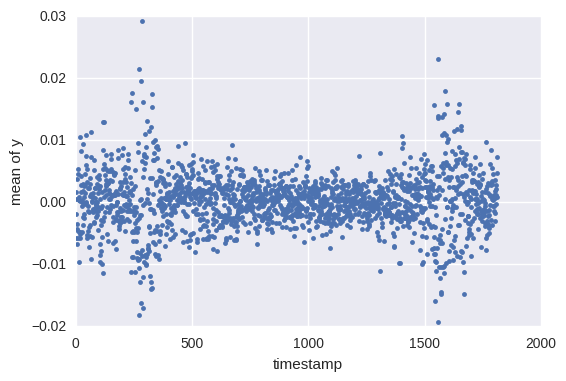

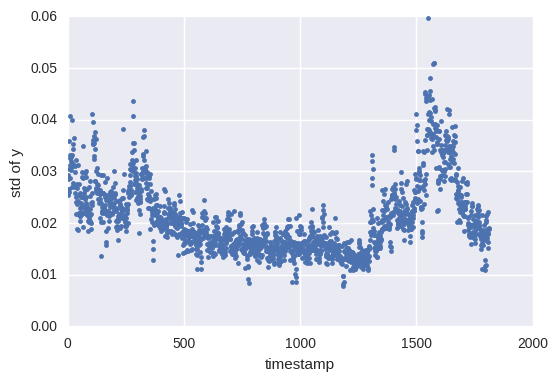

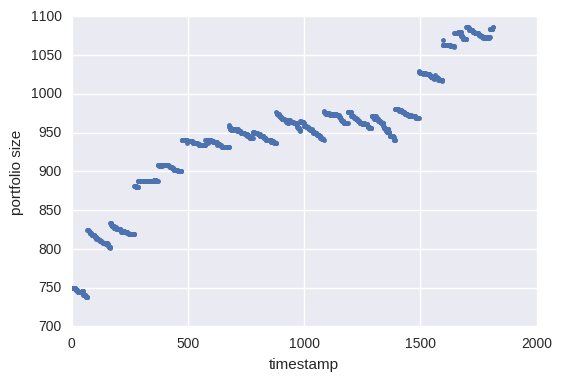

In [6]:
t      = market_df['timestamp']
y_mean = np.array(market_df['y']['mean'])
y_std  = np.array(market_df['y']['std'])
n      = np.array(market_df['y']['len'])

# These scatter plots are very similar to the histograms that I have further down. 

# This one below shows similar information to what I already have somewhere else. 
plt.figure()
plt.plot(t, y_mean, '.')
plt.xlabel('timestamp')
plt.ylabel('mean of y')

# Std shows a similar picture to the one above. 
plt.figure()
plt.plot(t, y_std, '.')
plt.xlabel('timestamp')
plt.ylabel('std of y')

plt.figure()
plt.plot(t, n, '.')
plt.xlabel('timestamp')
plt.ylabel('portfolio size')

Looks like two periods of high variance that are correlated with rapid increases in the number of assets. The number of assets being tracked increases from 750 in the first timestamp to just under 1100 in the last.
The total number of assets across all timestamps is 1424, so some assets are being dropped as well. It looks like assets are added to the portfolio periodically (see the gaps in the chart), and sold off more slowly.
Let's derive a price chart for these returns. We can take the log of the periodic mean returns and get a cumulative sum for each time period to derive a fairly good approximation of a price chart for the portfolio.

**Of course this makes sense they provided ius with a portfolio of stocks**

In [ ]:
n=-3
y_mean

In [ ]:
cum_ret = np.log(1+y_mean).cumsum()

#ln(1+ret) = is going to give you return. 

# log(1 + r_i) = log(\frac{p_i}{p_j}) = \log(p_i) - log(p_j) 


#cum_ret = np.array(1+y_mean)*(y_mean[-n]).cumsum()
#fuck yea nb, go length for for loop, if you do not want ot go into the elements.
# Even more important range seems to be the important one

#for n in range(len(y_mean)):
#    cum_new = (1+y_mean[n])*(y_mean[n+1])

# This above is definitely wrong.
#.cumsum()
#cum_ret
cum_ret


In [ ]:
plt.figure()
plt.plot(t, cum_ret)
plt.xlabel('timestamp')
plt.ylabel('portfolio value')

Taking the log returns and adding them up is a good approximation for the compounding of returns.
I tried the right method, but I fucked it up.


In [ ]:
plt.figure()
plt.plot(t, y_mean)
plt.xlabel('timestamp')
plt.ylabel('portfolio value')

In [ ]:
assets_df = df.groupby('id')['y'].agg(['mean','std',len]).reset_index()
assets_df.head()

In [ ]:
assets_df = assets_df.sort_values(by='mean')
assets_df.head()

In [ ]:
assets_df.tail()

In [ ]:
assets_df.describe()

Looks like individual asset returns range from a min of -0.035077 to a high of 0.010827, with a mean return of 0.000186 and a std dev of 0.001884.
Assets have a mean holding period of roughly 1201 periods with a std dev of 646 periods, with a min holding period of 2 and a max of 1813 (all periods).

In [ ]:
sns.distplot(assets_df['mean'], rug=True, hist=False)

In [ ]:
assets_df.corr()

In [ ]:
g = sns.PairGrid(assets_df, vars=["mean", "std", "len"])
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)

There seem to be some interesting relationships here. Notably, mean asset returns and holding period are negatively correlated with the std dev of returns.
Thanks for visiting! Next I'm going to look at time series of individual asset return and correlation with the portfolio returns...


In [ ]:
corr = df.iloc[:,2:-1].corrwith(df.y)
print('max_correlation', corr.max().max())
print('min_correlation', corr.min().min())

In [ ]:
df.groupby('id').size().hist(bins=500)
# This shows you how much timestamps there is per id.
# Remember that there is about 1000 unique ids


In [ ]:
# This is actually so weitd that there is that many for each.
df_full.groupby('id').size().value_counts().head(5)

In [ ]:
# It seems that stuff that I cut away took a lot of the frequent occuring
# assets

In [ ]:
df.groupby('id').size().value_counts().head(5)

In [ ]:
size = df_full.groupby('id').size()
print(len(size), max(size))
assets = size[size==1813].index.values
print(len(assets))

correlations = pd.DataFrame()

for asset in assets:
    
    df2 = df_full[df_full.id==asset]
    corr = df2.drop(['id', 'timestamp', 'y'], axis=1).corrwith(df2.y)
    correlations[asset] = corr

correlations.head()


From this we can see that NaN values are present in all columns but two  (tech_22 & 34)

In [ ]:
plt.figure(figsize=(8,15))
sns.heatmap(correlations, vmin=-0.22, vmax=0.22)

In [ ]:
def get_reward(y_true, y_fit):
    R2 = 1 - np.sum((y_true - y_fit)**2) / np.sum((y_true - np.mean(y_true))**2)
    R = np.sign(R2) * math.sqrt(abs(R2))
    return(R)

In [ ]:
# Some pre-processing as seen from most of the public scripts.
# The "environment" is our interface for code competitions

# observation = env.reset()

# We get our initial observation by calling "reset


In [ ]:
observation = environment.reset()
cols_to_use_one = ['technical_20']

# model build
rid = Ridge()
fit_three = rid.fit(np.array(df[cols_to_use].values), df["y"].values)

# getting the y mean dict for averaging
ymean_dict = dict(observation.train.groupby(["id"])["y"].mean())

# weighted average of model & mean
def get_weighted_y(series):
    id, y = series["id"], series["y"]
    return 0.95 * y + 0.05 * ymean_dict[id] if id in ymean_dict else y

y_actual_list = []
y_pred_list = []
r1_overall_reward_list = []
ts_list = []
while True:
    timestamp = observation.features["timestamp"][0]
    actual_y = list(df_full[df_full["timestamp"] == timestamp]["y"].values)
    observation.features.fillna(d_mean, inplace=True)
    test_x = np.array(observation.features[cols_to_use].values)
    observation.target.y = fit_three.predict(test_x).clip(min_y, max_y)
    
    ## weighted y using average value
    observation.target.y = observation.target.apply(get_weighted_y, axis = 1)
    target = observation.target
    observation, reward, done, info = environment.step(target)
    
    if timestamp % 100 == 0:
        print("Timestamp #{}".format(timestamp))
    
    pred_y = list(target.y.values)
    y_actual_list.extend(actual_y)
    y_pred_list.extend(pred_y)
    overall_reward = get_reward(np.array(y_actual_list), np.array(y_pred_list))
    r1_overall_reward_list.append(overall_reward)
    ts_list.append(timestamp)
    if done:
        break
    
print(info)






In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(ts_list, r1_overall_reward_list, c='blue')
plt.plot(ts_list, [0]*len(ts_list), c='red')
plt.title("Cumulative R value change for Univariate Ridge (technical_20)")
plt.ylim([-0.04,0.04])
plt.xlim([850, 1850])
plt.show()

In [ ]:
observation = environment.reset()
cols_to_use_two = ['technical_20', 'technical_30', 'fundamental_15'] 
# model build
rid = Ridge()
fit_four = rid.fit(np.array(df[cols_to_use_two].values), df["y"].values)

# getting the y mean dict for averaging
ymean_dict = dict(observation.train.groupby(["id"])["y"].mean())

# weighted average of model & mean
def get_weighted_y(series):
    id, y = series["id"], series["y"]
    return 0.95 * y + 0.05 * ymean_dict[id] if id in ymean_dict else y

y_actual_list = []
y_pred_list = []
r3_overall_reward_list = []
ts_list = []
while True:
    timestamp = observation.features["timestamp"][0]
    actual_y = list(df_full[df_full["timestamp"] == timestamp]["y"].values)
    observation.features.fillna(d_mean, inplace=True)
    test_x = np.array(observation.features[cols_to_use_two].values)
    observation.target.y = fit_four.predict(test_x).clip(min_y, max_y)
    
    ## weighted y using average value
    observation.target.y = observation.target.apply(get_weighted_y, axis = 1)
    target = observation.target
    observation, reward, done, info = environment.step(target)
    
    if timestamp % 100 == 0:
        print("Timestamp #{}".format(timestamp))
    
    pred_y = list(target.y.values)
    y_actual_list.extend(actual_y)
    y_pred_list.extend(pred_y)
    overall_reward = get_reward(np.array(y_actual_list), np.array(y_pred_list))
    r3_overall_reward_list.append(overall_reward)
    ts_list.append(timestamp)
    if done:
        break
    
print(info)
